In [70]:
#Author: Amit M Shankarikoppa
#Date created: 2nd May 2017

#make sure to install these python packages before running the code
import pandas as pd
import numpy as np
import re
import itertools
from collections import OrderedDict
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')

In [3]:
# reads data from log and returns Dataframe object
def getData():
    df = pd.read_csv('ggevent.log', header=None, delimiter=',',
                       names='ai5 debug random sdkv event ts params timestamp game_id'.split(), parse_dates= True)
    timestampSeries = df.timestamp.apply(lambda x: x.split(':',2)[-1].replace("\"", ""))
    logFrame = df.applymap(lambda x: x.replace("{","").replace("}","").replace("\"","").split(":")[-1])
    logFrame['timestamp'] = timestampSeries
    logFrame['timestamp'] = pd.to_datetime(logFrame['timestamp'])
    
    # group data based on user ID or ai5 and sort timestamps for each user
    groupedData = logFrame.sort_values(['ai5', 'timestamp'], ascending = [True, True]).reset_index()
    groupedData = groupedData.drop('index', axis = 1)
    finalData = [group.reset_index() for _, group in groupedData.groupby('ai5')]
    return finalData

In [4]:
# # Algorithm to calculate sessions for each user, returns dictionary with key as user id and value as list of sessions
# # Algorithm uses looping, enhancements can be done using pandas dataframe way(complicated but effecient).
# def loopedSessionCalculator(finalDataFrame):
    
#     loopedSessionCalculator.session_dict = {}
    
#     for group in finalDataFrame:
#         loopedSessionCalculator.start_index = 0
#         loopedSessionCalculator.stop_index = 0
#         loopedSessionCalculator.session_time = 0
#         loopedSessionCalculator.new_session = True
        
#         for i in range(len(group.index)):
#             session_started = False
#             # identify the start of session
#             if('ggstart' in group.ix[i].event):
#                 sessrion_started = True
                
#                 if(i > 1):
#                     inter_sessionTime =  pd.Timedelta(group.ix[loopedSessionCalculator.stop_index].timestamp - group.ix[loopedSessionCalculator.start_index].timestamp).seconds
                    
#                     if(inter_sessionTime < 30):
#                         loopedSessionCalculator.new_session = False
               
#                 loopedSessionCalculator.start_index = i
#             #identify stop of session (consecutive starts and stops are identified to be valid)
#             elif('ggstop' in group.ix[i].event and sessrion_started):
#                 session_started = False
#                 loopedSessionCalculator.stop_index = i;
#                 loopedSessionCalculator.session_stop = group.ix[i].timestamp
#                 loopedSessionCalculator.session_time += pd.Timedelta(group.ix[i].timestamp - group.ix[loopedSessionCalculator.start_index].timestamp).seconds
            
#             if(loopedSessionCalculator.session_time > 1 and not session_started and loopedSessionCalculator.new_session):
#                 loopedSessionCalculator.session_dict.setdefault(group.ix[0].ai5,[]).append(loopedSessionCalculator.session_time)
#                 loopedSessionCalculator.session_time = 0
#                 loopedSessionCalculator.new_session = True
                
#     return loopedSessionCalculator.session_dict

In [19]:
#main code snippet
finalData = getData()
sessionDict = loopedSessionCalculator(finalData)
sessionFrame = pd.DataFrame([sessionDict]).transpose()
sessionFrame.rename(columns= {0:'Sessions'}, inplace = True) 
#Create column for number of sessions for each user id
sessionFrame['Number_of_sessions'] = sessionFrame['Sessions'].apply(lambda x: len(x))
# Extract valied sessions from all sessions
sessionFrame['Valid_sessions'] = sessionFrame['Sessions'].apply(lambda x: sum(1 for i in x if i > 60))
#Calculate average of valid sessions
sessionFrame['Average_valid'] = sessionFrame['Sessions'].apply(lambda x: (sum(i for i in x if i > 60) / sum(1 for i in x if i > 60)) if sum(1 for i in x if i > 60) > 0 else 0)


TypeError: '>' not supported between instances of 'dict' and 'int'

In [20]:
sessionFrame
finalData = getData()
sessionDict = loopedSessionCalculator(finalData)

Number of Valid Sessions summary statistics:
count    12374.000000
mean         2.140537
std          3.177787
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         33.000000
Name: Valid_sessions, dtype: float64
Valid Average Session values summary statistics:
count    7843.00000
mean      221.02737
std       253.17136
min        61.00000
25%       111.06250
50%       147.00000
75%       210.00000
max      3418.00000
Name: Average_valid, dtype: float64


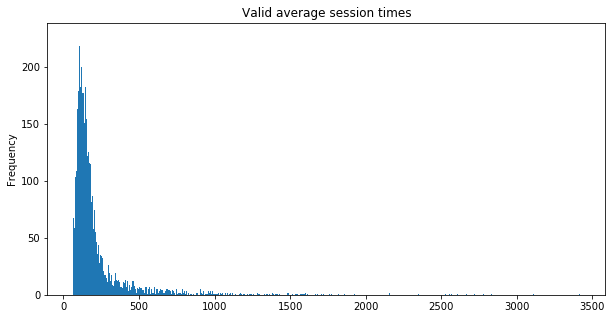

In [12]:
print("Number of Valid Sessions summary statistics:")
print(sessionFrame.Valid_sessions.describe())
#sessionFrame.Valid_sessions.hist(grid = False)
print("Valid Average Session values summary statistics:")
print(sessionFrame[sessionFrame['Average_valid'] > 0].Average_valid.describe())
sessionFrame[sessionFrame['Average_valid'] > 0].Average_valid.plot(kind= 'hist',bins= 1000, figsize = (10,5), title ='Valid average session times')


In [90]:
def loopedSessionCalculator(finalDataFrame):
    
    loopedSessionCalculator.session_dict = {}
    
    
    for group in finalDataFrame:
        loopedSessionCalculator.start_index = 0
        loopedSessionCalculator.stop_index = 0
        loopedSessionCalculator.session_time = 0
        loopedSessionCalculator.new_session = True
        loopedSessionCalculator.sdkwise = {}
        for i in range(len(group.index)):
            session_started = False
            loopedSessionCalculator.session_dict.setdefault(group.ix[0].ai5,[])
            # identify the start of session
            if('ggstart' in group.ix[i].event):
                sessrion_started = True
                
                if(i > 1):
                    inter_sessionTime =  pd.Timedelta(group.ix[loopedSessionCalculator.stop_index].timestamp - group.ix[loopedSessionCalculator.start_index].timestamp).seconds
                    
                    if(inter_sessionTime < 30):
                        loopedSessionCalculator.new_session = False
               
                loopedSessionCalculator.start_index = i
            #identify stop of session (consecutive starts and stops are identified to be valid)
            elif('ggstop' in group.ix[i].event and sessrion_started):
                session_started = False
                loopedSessionCalculator.stop_index = i;
                loopedSessionCalculator.session_stop = group.ix[i].timestamp
                loopedSessionCalculator.session_time += pd.Timedelta(group.ix[i].timestamp - group.ix[loopedSessionCalculator.start_index].timestamp).seconds
            
            if(loopedSessionCalculator.session_time > 1 and not session_started and loopedSessionCalculator.new_session):
                loopedSessionCalculator.session_dict[group.ix[0].ai5].append(loopedSessionCalculator.session_time)
                loopedSessionCalculator.session_time = 0
                loopedSessionCalculator.new_session = True
                
    return loopedSessionCalculator.session_dict

In [82]:
#finalData = getData()
sessionDict = loopedSessionCalculator(finalData)
type(finalData)
#print(type(sessionDict))
sessionFrame = pd.DataFrame([sessionDict]).transpose()
#sessionFrame

In [83]:
sessionFrame = pd.DataFrame([sessionDict]).transpose()
#list(OrderedDict.fromkeys(sessionFrame.ix[0].values))
sessionFrame

,0
00057368e3db67e8db27dc415209cc92,"[ 7.6, 113, 7.6, 230, 7.6, 156, 7.6, 165, ..."
0006df67ddcf576f4d38edd46c10b5a1,"[ 7.5.1, 13]"
00071e48377752c551d9ecda33c55945,"[ 7.5.1, 12]"
000c6c4d3976e75a32d422bdda89f9e5,"[ 7.6, 305, 7.6, 5]"
000d2688374c44397a3f94dd975cffb4,"[ 7.6, 87]"
000e3141a0b69405f75c877396a988ba,"[ 7.6, 385, 7.6, 59, 7.6, 21]"
00129e2c2eeb77cd45de41d5e8440934,"[ 7.6, 225, 7.6, 150]"
00145d2801465edb6be8cacbc0e12052,"[ 7.6, 36]"
0017f165b1ff5a98d293ad687dc63fa0,"[ 8.0, 262]"
0018d7805ba3166e698953d74dec8873,"[ 7.5.1, 30, 7.5.1, 2]"


In [89]:
a = ['a', 1]
a = {}
a['x'] = [],[]
a

{'x': ([], [])}